In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree
import statsmodels.formula.api as smf
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import contextily as ctx
from shapely.geometry import box, LineString, MultiLineString, Point

# 1. Importing the data

In [13]:
zcta_path = Path.cwd().parent / 'data' / 'raw' / 'zcta5_data' / 'zcta5.shp'
zcta = gpd.read_file(zcta_path)
zcta = zcta.to_crs("EPSG:4326")
zcta = gpd.GeoDataFrame(zcta, geometry=zcta["geometry"], crs="EPSG:4326")
zcta.columns = zcta.columns.str.lower()

# importing the data for the first batch of datacenters for which the conversion address -> coordinates worked
datacenters_path = Path.cwd().parent / 'data' / 'processed' / 'successful1.csv'
datacenters = pd.read_csv(datacenters_path)
datacenters.drop('Unnamed: 0', inplace=True, axis=1)


# Convert datacenters to GeoDataFrame
gdf_datacenters = gpd.GeoDataFrame(
    datacenters, 
    geometry=gpd.points_from_xy(datacenters["longitude"], datacenters["latitude"]),
    crs="EPSG:4326"
)
gdf_datacenters.rename({'ZCTA5': 'zcta5'}, axis=1, inplace=True)


# importing the cell tower data
towers_path = Path.cwd().parent / 'data' / 'processed' / 'cell_towers_processed.csv'
towers = pd.read_csv(towers_path)
towers.drop('Unnamed: 0', inplace=True, axis=1)

# Convert cell towers to GeoDataFrame
gdf_towers = gpd.GeoDataFrame(
    towers, 
    geometry=gpd.points_from_xy(towers["lon"], towers["lat"]),
    crs="EPSG:4326"
)
gdf_towers.rename({'ZCTA5': 'zcta5'}, axis=1, inplace=True)

pop_path = Path.cwd().parent / 'data' / 'raw' / 'Population-Density-Final.xlsx'
pop = pd.read_excel(pop_path, sheet_name='DATA')
pop.rename({'Zip': 'zcta5'}, axis=1, inplace=True)
pop["zcta5"] = pop["zcta5"].astype(str)


energy_path = Path.cwd().parent / 'data' / 'raw' / 'transmission_line_data' / 'Electric_Power_Transmission_Lines_B.shp'
energy =  gpd.read_file(energy_path)
energy.rename({'ZCTA5': 'zcta5'}, axis=1, inplace=True)
energy = energy.to_crs('EPSG:4326')

In [14]:
# ✅ Define the voltage classification function
def classify_voltage(voltage):
    if voltage < 1:
        return "Low Voltage (<1kV)"
    elif 1 <= voltage < 69:
        return "Medium Voltage (1-69kV)"
    elif 69 <= voltage < 230:
        return "High Voltage (69-230kV)"
    elif 230 <= voltage < 765:
        return "Extra-High Voltage (230-765kV)"
    else:
        return "Ultra-High Voltage (>765kV)"

# ✅ Apply classification
energy["Voltage_Class"] = energy["VOLTAGE"].apply(classify_voltage)

In [35]:
# ✅ Define Dallas bounding box (approximate lat/lon range)
dallas_bbox = {
    "minx": -97.5, "maxx": -96.5,
    "miny": 32.5, "maxy": 33.3
}
dallas_geom = box(dallas_bbox["minx"], dallas_bbox["miny"], dallas_bbox["maxx"], dallas_bbox["maxy"])

energy_dallas = energy[energy.geometry.intersects(dallas_geom)].copy()
gdf_datacenters_dallas = gdf_datacenters[gdf_datacenters.geometry.intersects(dallas_geom)].copy()
gdf_towers_dallas = gdf_towers[gdf_towers.geometry.intersects(dallas_geom)].copy()

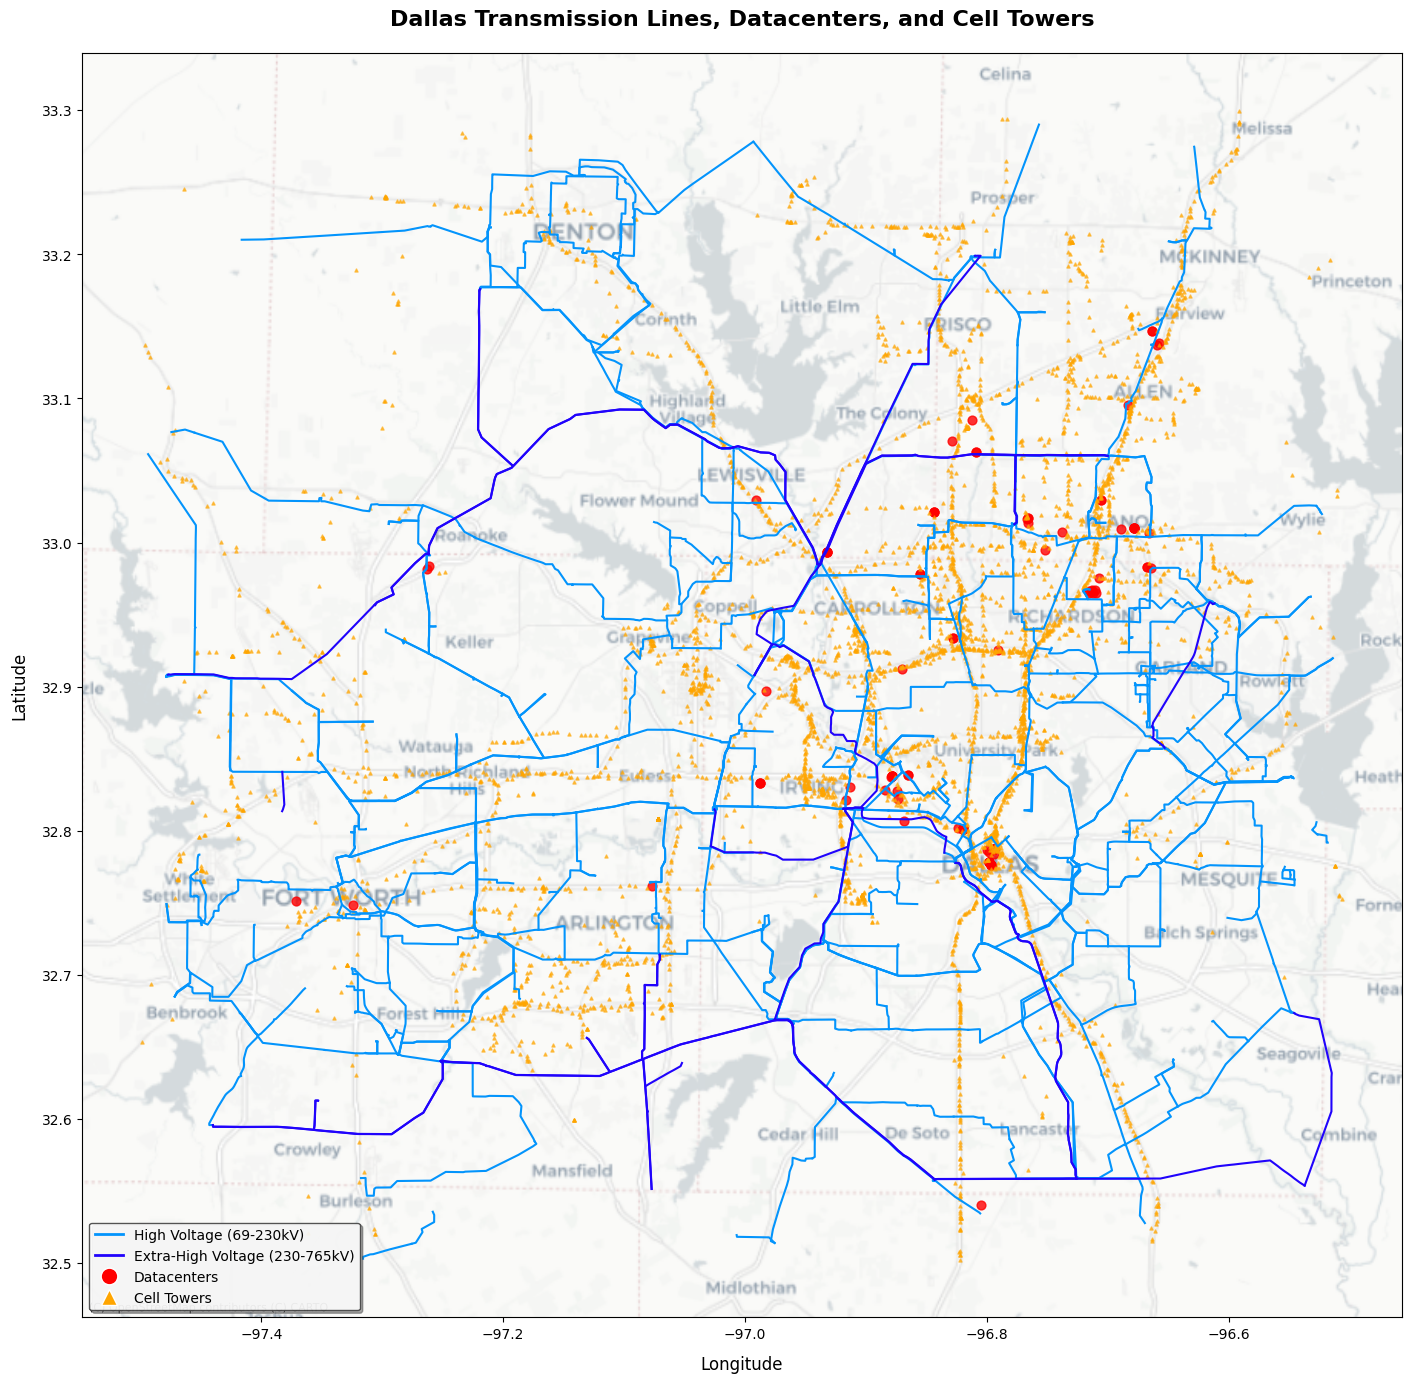

In [36]:
# ✅ Filter transmission lines within Dallas
energy_dallas_filtered = energy_dallas[
    (energy_dallas.geometry.bounds.minx >= dallas_bbox["minx"]) & 
    (energy_dallas.geometry.bounds.maxx <= dallas_bbox["maxx"]) & 
    (energy_dallas.geometry.bounds.miny >= dallas_bbox["miny"]) & 
    (energy_dallas.geometry.bounds.maxy <= dallas_bbox["maxy"])
]

# ✅ Filter only High Voltage and Extra-High Voltage lines
energy_dallas_filtered = energy_dallas_filtered[
    energy_dallas_filtered["Voltage_Class"].isin(["High Voltage (69-230kV)", "Extra-High Voltage (230-765kV)"])
]

# ✅ Filter datacenters within Dallas
gdf_datacenters_dallas = gdf_datacenters[
    (gdf_datacenters.geometry.x >= dallas_bbox["minx"]) & 
    (gdf_datacenters.geometry.x <= dallas_bbox["maxx"]) & 
    (gdf_datacenters.geometry.y >= dallas_bbox["miny"]) & 
    (gdf_datacenters.geometry.y <= dallas_bbox["maxy"])
]

# ✅ Filter cell towers within Dallas
gdf_towers_dallas = gdf_towers[
    (gdf_towers.geometry.x >= dallas_bbox["minx"]) & 
    (gdf_towers.geometry.x <= dallas_bbox["maxx"]) & 
    (gdf_towers.geometry.y >= dallas_bbox["miny"]) & 
    (gdf_towers.geometry.y <= dallas_bbox["maxy"])
]

# ✅ Define voltage classification colors (Only High & Extra-High)
voltage_colors = {
    "High Voltage (69-230kV)": "#0394fc",
    "Extra-High Voltage (230-765kV)": "#2003fc",
}

# ✅ Plot Everything Together
fig, ax = plt.subplots(figsize=(14, 14), constrained_layout=True)

# ✅ Plot Transmission Lines (Only High & Extra-High Voltage)
for category, color in voltage_colors.items():
    subset = energy_dallas_filtered[energy_dallas_filtered["Voltage_Class"] == category]
    for line in subset.geometry:
        if isinstance(line, LineString):
            x, y = line.xy
            ax.plot(x, y, color=color, linewidth=1.5, label=category)
        elif isinstance(line, MultiLineString):
            for segment in line.geoms:
                x, y = segment.xy
                ax.plot(x, y, color=color, linewidth=1.5, label=category)

# ✅ Plot Datacenters (Red Circles)
gdf_datacenters_dallas.plot(ax=ax, color="red", markersize=40, label="Datacenters", alpha=0.8)

# ✅ Plot Cell Towers (Orange Triangles)
gdf_towers_dallas.plot(ax=ax, color="orange", markersize=5, marker="^", label="Cell Towers", alpha=0.6)

# ✅ Add a basemap
ctx.add_basemap(ax, crs=gdf_datacenters_dallas.crs, source=ctx.providers.CartoDB.Positron)

# ✅ Formatting
ax.set_title("Dallas Transmission Lines, Datacenters, and Cell Towers", fontsize=16, pad=20, weight="bold")
ax.set_xlabel("Longitude", fontsize=12, labelpad=10)
ax.set_ylabel("Latitude", fontsize=12, labelpad=10)

# ✅ Create a Custom Legend with Correct Icons
legend_elements = [
    # Transmission Lines (lines in legend)
    mlines.Line2D([], [], color="#0394fc", linewidth=2, label="High Voltage (69-230kV)"),
    mlines.Line2D([], [], color="#2003fc", linewidth=2, label="Extra-High Voltage (230-765kV)"),
    
    # Datacenters (circle markers with white edge)
    mlines.Line2D([], [], 
                 marker='o', 
                 color='red',            # Inner color
                 markeredgecolor='white', # Edge color
                 markersize=12,          # Size relative to legend
                 linestyle='None',
                 label="Datacenters"),
    
    # Cell Towers (triangle markers with white edge)
    mlines.Line2D([], [], 
                 marker='^', 
                 color='orange',         # Inner color
                 markeredgecolor='white', # Edge color
                 markersize=12,          # Size relative to legend
                 linestyle='None',
                 label="Cell Towers")
]

# ✅ Add legend with proper styling
ax.legend(handles=legend_elements, 
          loc="lower left", 
          fontsize=10, 
          title_fontsize=12,
          frameon=True, 
          shadow=True, 
          facecolor='white',
          edgecolor='#404040',
          framealpha=0.9)

# ✅ Show the map
plt.show()

In [40]:
# ✅ Assign ZIP codes to datacenters
gdf_datacenters = gdf_datacenters.sjoin(zcta, predicate="within")

# ✅ Assign ZIP codes to cell towers
gdf_towers = gdf_towers.sjoin(zcta, predicate="within")

# Perform spatial join: Assign ZIP codes to transmission lines
energy = gpd.sjoin(energy, zcta, predicate="intersects")

# ✅ Keep only relevant columns
gdf_datacenters = gdf_datacenters[["zcta5", "geometry"]]
gdf_towers = gdf_towers[["zcta5", "geometry"]]


# Count datacenters per ZIP code
datacenter_counts = gdf_datacenters.groupby("zcta5").size().reset_index(name="datacenter_count")

# Count cell towers per ZIP code
tower_counts = gdf_towers.groupby("zcta5").size().reset_index(name="tower_count")

In [45]:
# ✅ Convert energy dataset to a projected CRS (e.g., EPSG:3857 or EPSG:5070 for the US)
if energy.crs != "EPSG:3857":  # EPSG:3857 is Web Mercator (meters)
    energy = energy.to_crs("EPSG:3857")

# ✅ Compute line length in kilometers
energy["line_length_km"] = energy.geometry.length / 1000  # Convert meters to km
line_density = energy.groupby("zcta5")["line_length_km"].sum().reset_index()

# Merge population density with infrastructure data
merged_df = pop.merge(datacenter_counts, on="zcta5", how="left")
merged_df = merged_df.merge(tower_counts, on="zcta5", how="left")
merged_df = merged_df.merge(line_density, on="zcta5", how="left")

# Fill NaN values (since some ZIPs may have no datacenters or towers)
merged_df.fillna(0, inplace=True)

# ✅ Ensure the CRS is in a projected coordinate system for accurate area calculation
if zcta.crs != "EPSG:3857":  
    zcta = zcta.to_crs("EPSG:3857")  # Convert to a metric-based CRS (meters)

# ✅ Compute area in square kilometers
zcta["area_km2"] = zcta.geometry.area / 1e6  # Convert from square meters to square kilometers

# ✅ Keep only necessary columns
zcta_area = zcta[["zcta5", "area_km2"]]

# ✅ Merge the area data with the existing dataset
merged_df = merged_df.merge(zcta_area, left_on="zcta5", right_on="zcta5", how="left")

In [46]:
# ✅ Compute density of cell towers
merged_df["tower_density_km2"] = merged_df["tower_count"] / merged_df["area_km2"]


In [47]:
# ✅ Convert to a binary target variable
merged_df["datacenter_built"] = (merged_df["datacenter_count"] > 0).astype(int)

# ✅ Drop the original `datacenter_count` column
merged_df.drop(columns=["datacenter_count"], inplace=True)


In [48]:
merged_df.drop(columns=["City", "St", "CitySt", "County", "Country", "Coordinates"], inplace=True)

# Machile Learning Modelling

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [51]:
# ✅ Select features to normalize
cols_to_scale = ["population", "density", "tower_density_km2"]

# ✅ Apply MinMaxScaler
scaler = MinMaxScaler()
merged_df[cols_to_scale] = scaler.fit_transform(merged_df[cols_to_scale])
merged_df.drop('State', axis=1, inplace=True)

In [52]:
merged_df.fillna(0, inplace=True)  # Replace NaNs with 0

In [53]:
# ✅ Define features (X) and target (y)
X = merged_df.drop(columns=["datacenter_built", "zcta5"])  # Exclude target & ZIP code
y = merged_df["datacenter_built"]  # Binary target (1 = datacenter built)

# ✅ Train Logistic Regression Model on Full Dataset
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# ✅ Predict probabilities for all ZIP codes in the dataset
merged_df["predicted_prob"] = model.predict_proba(X)[:, 1]  # Extract probability of "1"


In [54]:
zcta_map = zcta.merge(merged_df, left_on="zcta5", right_on="zcta5", how="left")

In [55]:
# ✅ Define Dallas bounding box (approximate lat/lon range)
dallas_bbox = {
    "minx": -97.5, "maxx": -96.5,
    "miny": 32.5, "maxy": 33.3
}

# ✅ Separate Dallas region (Test Set)
dallas_df = merged_df[
    (merged_df["long"] >= dallas_bbox["minx"]) & (merged_df["long"] <= dallas_bbox["maxx"]) &
    (merged_df["lat"] >= dallas_bbox["miny"]) & (merged_df["lat"] <= dallas_bbox["maxy"])
].copy()

# ✅ Define the Train Set (Everything except Dallas)
train_df = merged_df.drop(dallas_df.index)

# ✅ Define features (X) and target (y) for training
X_train = train_df.drop(columns=["datacenter_built", "zcta5"])
y_train = train_df["datacenter_built"]

# ✅ Train Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [56]:
# ✅ Define features for Dallas Test Set
X_test_dallas = dallas_df.drop(columns=["zcta5", "datacenter_built"])

# ✅ Predict probabilities for Dallas
dallas_df["predicted_prob"] = model.predict_proba(X_test_dallas)[:, 1]

In [57]:
zcta_dallas = zcta.merge(dallas_df, left_on="zcta5", right_on="zcta5", how="inner")

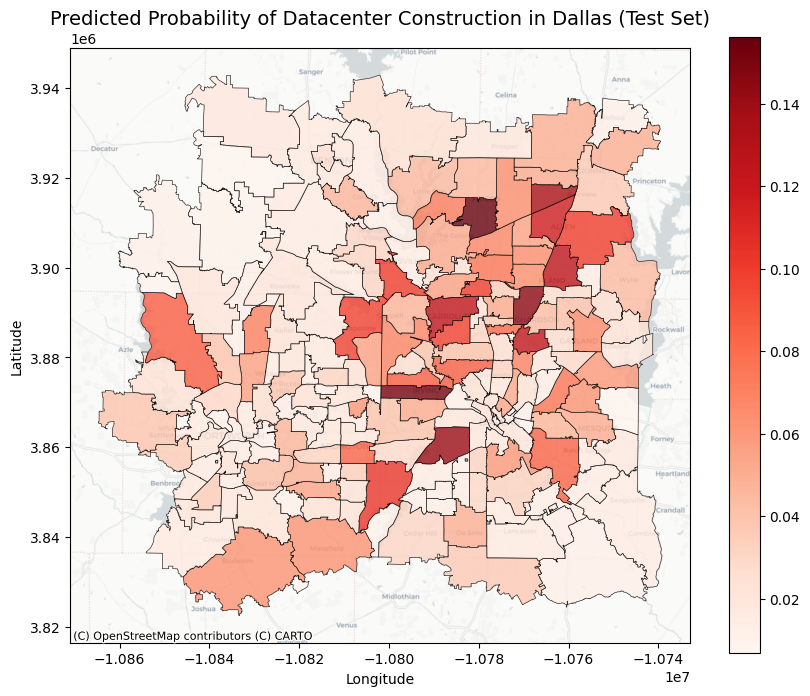

In [58]:
# ✅ Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))

# ✅ Plot Dallas ZIP codes with predicted probabilities
zcta_dallas.plot(column="predicted_prob", cmap="Reds", linewidth=0.5, edgecolor="black",
                 legend=True, alpha=0.8, ax=ax)

# ✅ Add a basemap for geographic context
ctx.add_basemap(ax, crs=zcta_dallas.crs, source=ctx.providers.CartoDB.Positron)

# ✅ Formatting
ax.set_title("Predicted Probability of Datacenter Construction in Dallas (Test Set)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# ✅ Show the map
plt.show()

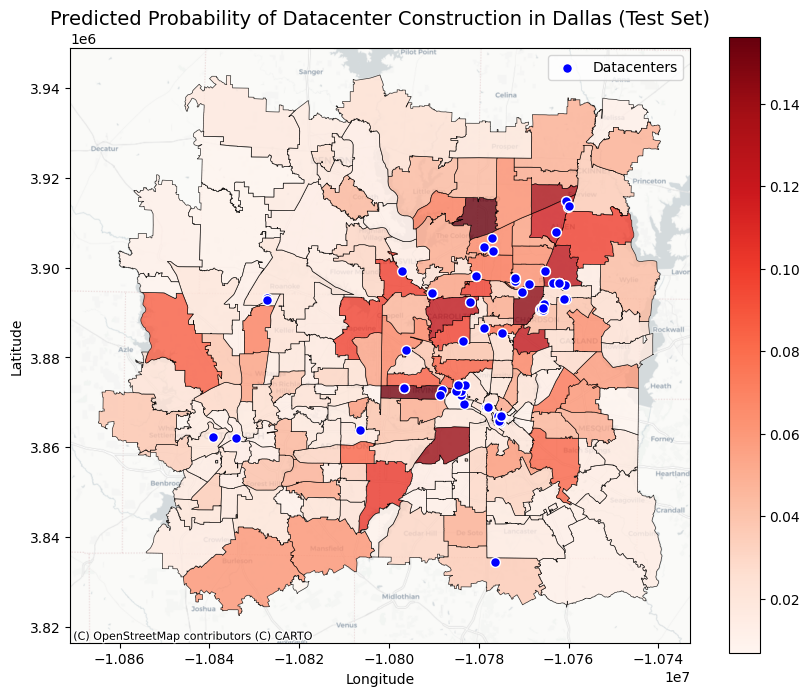

In [59]:
# ✅ Reproject datacenters to match ZCTA CRS if necessary
if gdf_datacenters_dallas.crs != zcta_dallas.crs:
    gdf_datacenters_dallas = gdf_datacenters_dallas.to_crs(zcta_dallas.crs)

# ✅ Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))

# ✅ Plot Dallas ZIP codes with predicted probabilities
zcta_dallas.plot(column="predicted_prob", cmap="Reds", linewidth=0.5, edgecolor="black",
                 legend=True, alpha=0.8, ax=ax)

# ✅ Overlay datacenter locations
gdf_datacenters_dallas.plot(ax=ax, marker="o", color="blue", markersize=50, edgecolor="white", label="Datacenters")

# ✅ Add a basemap for geographic context
ctx.add_basemap(ax, crs=zcta_dallas.crs, source=ctx.providers.CartoDB.Positron)

# ✅ Formatting
ax.set_title("Predicted Probability of Datacenter Construction in Dallas (Test Set)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# ✅ Show the map
plt.show()
